# Walk on Spheres Applications and Experiments

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import tqdm
import math
import multiprocessing as mp

# Sampling

To implement the walk on spheres algorithms, we will need to implement some functions for sampling from spheres and balls. Since we will focus in this assignment on solving problems in 2D, this means we need to sample from 2D balls and 1D spheres (a.k.a. circles.)

## Sampling uniformly from a circle

In [3]:
def sampleFrom1DSphere(rng, x, r):
  # choose angle uniformly and convert to Cartesian
  angle = rng.random()*2*np.pi
  px = np.cos(angle)*r + x[0]
  py = np.sin(angle)*r + x[1]
  return np.array([px, py])


## Sampling uniformly from a ball

In [4]:
def sampleFrom2DBall(rng, x, r):
  # choose radius and angle uniformly and convert to Cartesian
  R = r * np.sqrt(rng.random())
  angle = rng.random() * 2 * np.pi
  px = np.cos(angle)*R + x[0]
  py = np.sin(angle)*R + x[1]

  return np.array([px, py])

Run the following cell to help you debug `sampleFrom1DSphere()` and `sampleFrom2DBall()`. It samples and plots $N$ (resp. $M$) points from each distribution.

<Figure size 640x480 with 0 Axes>

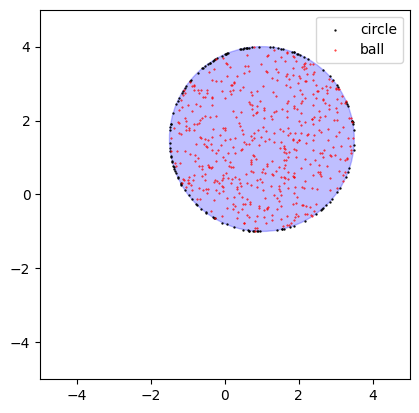

In [5]:
N = 128
M = 512
c = [1., 1.5]
r = 2.5
ext = 5

rng = np.random.default_rng()
samplesC = np.array([sampleFrom1DSphere(rng, c, r) for _ in range(N)])
samplesB = np.array([sampleFrom2DBall(rng, c, r) for _ in range(M)])

plt.figure()
ball = plt.Circle(c, r, color='b', alpha=0.25)
fig, ax = plt.subplots()
ax.set_xlim(-ext, ext)
ax.set_ylim(-ext, ext)
ax.set_aspect('equal')
ax.add_patch(ball)
ax.scatter(samplesC[:,0], samplesC[:,1], s=0.4, color='black', alpha=1.0, label='circle')
ax.scatter(samplesB[:,0], samplesB[:,1], s=0.2, color='red', alpha=1.0, label='ball')
ax.legend()

# Walk on Spheres (WoS) for Dirichlet-Laplace Problems

Consider the Laplace equation on a domain $\Omega$ with Dirichlet boundary conditions:

$$
\begin{align*}
\Delta u &= 0 \hspace{1cm} &\text{on $\Omega$} \\
u(x) &= g(x) &\text{on $\partial\Omega$.}
\end{align*}
$$

For example, if we interpret $g(x)$ as prescribing the amount of heat at the boundary $\partial\Omega$ of a spatial domain $\Omega$, then the solution $u(x)$ describes the amount of heat at a spatial location $x\in\Omega$ when the system has reached equilibrium. This type of problem (which doesn't necessarily have to describe heat) is an example of a [_Dirichlet problem_](https://en.wikipedia.org/wiki/Dirichlet_problem).

In [6]:
class DirichletProblem():

  def __init__(self, nWalks=16, maxSteps=128, epsilon=1e-1):
    self.nWalks = nWalks
    self.maxSteps = maxSteps
    self.epsilon = epsilon

  def solve(self, rng, x, d=1):
    estimate = np.zeros(d)
    for walk in range(self.nWalks):
      x_new = x.copy()
      for step in range(self.maxSteps):
        # Determine the minimum distance to the domain boundary.
        cp = self.closestPoint(x_new)
        R = np.linalg.norm(x_new - cp)
        if R < epsilon: break
        # Choose a point uniformly at random on the boundary of the ball of maximum radius centered at x contained inside the domain.
        x_new = sampleFrom1DSphere(rng, x_new, R)
      # Add contribution of boundary value to estimate.
      estimate += self.g(cp)

    # Return average over many walks.
    return estimate/nWalks

  def closestPoint(self, x):
    '''
    Return the closest point on the domain boundary to x.
    '''
    xprime = x.copy()
    while True:
      d = self.SDF(xprime)
      if abs(d) < self.epsilon: return xprime
      xprime -= d*self.gradientSDF(xprime)

  def gradientSDF(self, x, eps=1e-3):
    dx = np.array([eps, 0])
    dy = np.array([0, eps])
    ddx = self.SDF(x+dx) - self.SDF(x-dx)
    ddy = self.SDF(x+dy) - self.SDF(x-dy)
    g = np.array([ddx, ddy])
    g /= np.linalg.norm(g)
    return g

  def zeroSet(self, x, w=0.015):
    d = self.SDF(x)
    return np.clip(np.exp(-0.5*d*d/(w*w)), 0.0, 1.0)

  def SDF(self, x):
    '''
    Define the domain boundary via SDF.
    '''
    pass

  def g(self, x):
    '''
    Evaluate the boundary data g(x).
    '''
    pass


## Vector field interpolation
Run the following code cell to see an example of your WoS implementation in action. The cell below interpolates a vector field defined on the boundary of a domain into the domain interior, which can be cast as a Dirichlet-Laplace problem.

 16%|█▌        | 6/37 [00:00<00:03, 10.12it/s]

100%|██████████| 37/37 [00:04<00:00,  8.72it/s]


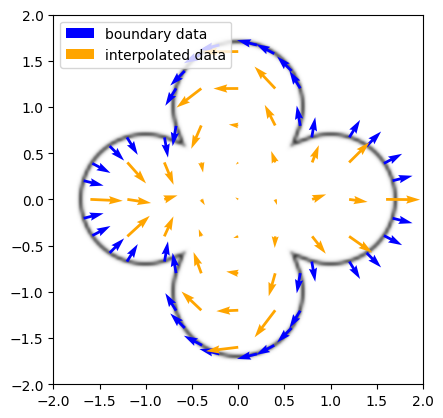

In [7]:
class VectorFieldInterpolation(DirichletProblem):

  def SDF(self, x):
    '''
    https://iquilezles.org/articles/distfunctions2d/=
    '''
    he = 0.8
    ra = 0.7
    pos = np.abs(x)
    pos = np.array([np.abs(pos[0]-pos[1]), 1.0-pos[0]-pos[1]]) / np.sqrt(2.)
    p = (he-pos[1]-0.25/he)/(6.0*he)
    q = pos[0]/(he*he*16.0)
    h = q*q-p*p*p
    y = 0.0
    if h > 0.:
      r = np.sqrt(h)
      y = np.power(q+r, 1./3.)-np.power(np.abs(q-r), 1./3.)*np.sign(r-q)
    else:
      r = np.sqrt(p)
      y = 2.0*r*np.cos(np.arccos(q/(p*r))/3.)
    y = min(y, np.sqrt(2.)/2.)
    z = np.array([y, he*(1.-2.*y*y)]) - pos
    return np.linalg.norm(z) * np.sign(z[1]) - ra

  def g(self, x):
    theta = np.arctan2(x[1],x[0])
    theta *= 2
    return np.array([np.cos(theta), np.sin(theta)])

nWalks = 64
maxSteps = 128
epsilon = 1e-2
nPixels = 128
size = 2
rng = np.random.default_rng()
VFI = VectorFieldInterpolation(nWalks, maxSteps, epsilon)
bGrid = np.array([[VFI.zeroSet(np.array([-size+(2*size/nPixels)*(i+0.5), -size+(2*size/nPixels)*(j+0.5)])) for j in range(nPixels)] for i in range(nPixels)])
bSamples = np.where(bGrid > 0.98)
bSamplePos = np.array([np.array([-size+(2*size/nPixels)*(bSamples[0][i]+0.5), -size+(2*size/nPixels)*(bSamples[1][i]+0.5)]) for i in range(len(bSamples[1]))])
bData = np.array([VFI.g(x) for x in bSamplePos])
solnSampleRate = 10
jitter = np.array([1e-3, 1e-3]) # gradient is poorly behaved at origin
queryPoints = np.array([[-size+(2*size/solnSampleRate)*i, -size+(2*size/solnSampleRate)*j] + jitter
                            for j in range(solnSampleRate)
                            for i in range(solnSampleRate)
                            if VFI.SDF(np.array([-size+(2*size/solnSampleRate)*i, -size+(2*size/solnSampleRate)*j])) < 0.0])
soln = np.array([VFI.solve(rng, queryPoints[i,:], 2) for i in tqdm.tqdm(range(queryPoints.shape[0]), position=0, leave=True)])

plt.figure()
bImage = plt.imshow(np.transpose(bGrid), interpolation='bicubic', cmap=plt.cm.Greys, origin='lower', extent=[-size, size, -size, size])
plt.quiver(bSamplePos[:,0], bSamplePos[:,1], bData[:,0], bData[:,1], angles='xy', color='blue', label="boundary data")
plt.quiver(queryPoints[:,0], queryPoints[:,1], soln[:,0], soln[:,1], angles='xy', color='orange', label="interpolated data")
plt.legend(loc="upper left")

## Cross field interpolation
The cell below interpolates a _cross field_ defined on the boundary of a domain into the domain interior, which can also be cast as a Dirichlet-Laplace problem.

100%|██████████| 63/63 [00:01<00:00, 34.39it/s]


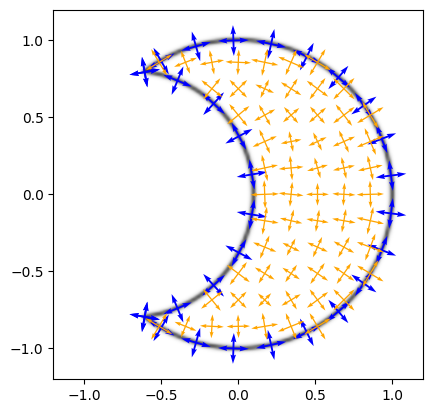

In [8]:
class CrossFieldInterpolation(DirichletProblem):

  def SDF(self, x):
    d = -0.7
    ra = 1.0
    rb = 0.8
    p = x.copy()
    p[1] = abs(p[1])
    a = (ra*ra - rb*rb + d*d)/(2.*d)
    b = np.sqrt(max(ra*ra-a*a, 0.))
    if d*(p[0]*b-p[1]*a) > d*d*max(b-p[1],0.):
      return np.linalg.norm(p-np.array([a,b]))
    return max(np.linalg.norm(p)-ra, -(np.linalg.norm(p-np.array([d,0]))-rb))

  def g(self, x):
    g = self.gradientSDF(x)
    t = complex(-g[1], g[0])
    v = t**4
    return np.array([v.real, v.imag])

nWalks = 64
maxSteps = 128
epsilon = 1e-2
nPixels = 128
size = 1.2
rng = np.random.default_rng()
CFI = CrossFieldInterpolation(nWalks, maxSteps, epsilon)
bGrid = np.array([[CFI.zeroSet(np.array([-size+(2*size/nPixels)*(i+0.5), -size+(2*size/nPixels)*(j+0.5)]),w=0.01) for j in range(nPixels)] for i in range(nPixels)])
bSamplePos = np.array([CFI.closestPoint(1.2*np.array([np.cos(x),np.sin(x)])) for x in np.linspace(-2*np.pi/3, 2*np.pi/3, 18)])
bSamplePos = np.append(bSamplePos, np.array([CFI.closestPoint(0.6*np.array([np.cos(x)-1.0,np.sin(x)])) for x in np.linspace(-2*np.pi/3, 2*np.pi/3, 12)]), axis=0)
def convertToCross(v):
  rv = complex(v[0],v[1])**(1./4.)
  return np.array([rv.real, rv.imag])
bData = np.array([convertToCross(CFI.g(x)) for x in bSamplePos])
solnSampleRate = 14
jitter = np.array([1e-3, 1e-3]) # gradient is poorly behaved at origin
queryPoints = np.array([[-size+(2*size/solnSampleRate)*i, -size+(2*size/solnSampleRate)*j] + jitter
                            for j in range(solnSampleRate)
                            for i in range(solnSampleRate)
                            if CFI.SDF(np.array([-size+(2*size/solnSampleRate)*i, -size+(2*size/solnSampleRate)*j])) < 0.0])
soln = np.array([convertToCross(CFI.solve(rng, queryPoints[i,:], 2)) for i in tqdm.tqdm(range(queryPoints.shape[0]), position=0, leave=True)])

plt.figure()
bImage = plt.imshow(np.transpose(bGrid), interpolation='bicubic', cmap=plt.cm.Greys, origin='lower', extent=[-size, size, -size, size])
scale = 10 # (inverse) length
iscale = 0.7
width = 0.005
bColor = 'blue'
iColor = 'orange'
# boundary data
plt.quiver(bSamplePos[:,0], bSamplePos[:,1], bData[:,0], bData[:,1], angles='xy', color=bColor, scale_units="xy", scale=scale, width=width)
plt.quiver(bSamplePos[:,0], bSamplePos[:,1], -bData[:,1], bData[:,0], angles='xy', color=bColor, scale_units="xy", scale=scale, width=width)
plt.quiver(bSamplePos[:,0], bSamplePos[:,1], -bData[:,0], -bData[:,1], angles='xy', color=bColor, scale_units="xy", scale=scale, width=width)
plt.quiver(bSamplePos[:,0], bSamplePos[:,1], bData[:,1], -bData[:,0], angles='xy', color=bColor, scale_units="xy", scale=scale, width=width)
# soln
plt.quiver(queryPoints[:,0], queryPoints[:,1], soln[:,0], soln[:,1], angles='xy', color=iColor, scale_units="xy", scale=scale, width=width*iscale)
plt.quiver(queryPoints[:,0], queryPoints[:,1], -soln[:,1], soln[:,0], angles='xy', color=iColor, scale_units="xy", scale=scale, width=width*iscale)
plt.quiver(queryPoints[:,0], queryPoints[:,1], -soln[:,0], -soln[:,1], angles='xy', color=iColor, scale_units="xy", scale=scale, width=width*iscale)
plt.quiver(queryPoints[:,0], queryPoints[:,1], soln[:,1], -soln[:,0], angles='xy', color=iColor, scale_units="xy", scale=scale, width=width*iscale)

# WoS for Dirichlet-Poisson Problems

More generally, we can consider a Laplace equation with a _source term_ on the right hand side, which results in what is usually called a _Poisson equation_. If we also prescribe Dirichlet boundary conditions, we obtain a _Dirichlet-Poisson problem_:

$$
\begin{align*}
\Delta u(x) &= f(x) \hspace{1cm} &\text{on $\Omega$} \\
u(x) &= g(x) &\text{on $\partial\Omega$.}
\end{align*}
$$

The only difference to the previous example is that we now must consider the contribution of the source term $f(x)$ to our estimate while we simulate random walks. Algorithmically, in the context of WoS, the presence of the source term means we must add to our estimate the source term contribution

$$
\int_{B_R(x)} f(y)G_R(x,y)\; {\rm d}y
$$

at each step of each walk of WoS, where $B_R(x)$ is the ball of maximal radius $R$ centered at $x$, and $G_R$ is the harmonic [_Green's function_](https://en.wikipedia.org/wiki/Green's_function) \([fundamental solution](https://en.wikipedia.org/wiki/Fundamental_solution)) on the ball $B_R(x)$,

$$
G_R(x,y) = \frac{1}{2\pi}\log(R/r) \hspace{2cm} r := \|x-y\|.
$$

For most source terms $f$, this integral can't be evaluated analytically so we have to approximate it numerically. For smooth, low-frequency source terms $f$, one-point quadrature is usually sufficient, where we sample a single sample $y\sim U(B_R(x))$ and evaluate

$$
\rm{Area}\left(B_R(x)\right) \cdot f(y) \cdot G(x,y).
$$

In [9]:
class DirichletPoissonProblem(DirichletProblem):

  def solve(self, rng, x, d=1):
    estimate = np.zeros(d)
    for walk in range(self.nWalks):
      x_new = x.copy()
      for step in range(self.maxSteps):
        # Determine the minimum distance to the domain boundary.
        cp = self.closestPoint(x_new)
        R = np.linalg.norm(x_new - cp)
        if R < epsilon: break
        y = sampleFrom2DBall(rng, x_new, R)
        estimate += ((np.pi*(R**2))*self.f(y) * self.G(R, x_new, y))
        x_new = sampleFrom1DSphere(rng, x_new, R)

      # Add contribution of boundary value to estimate.
      estimate += self.g(cp)

    # Return average over many walks.
    return estimate/self.nWalks

  def G(self, R, x, y):
    '''
    Evaluate the harmonic Green's function on the ball of radius `R` centered at
    `x`, evaluated at `y`.
    '''
    r = np.linalg.norm(x-y)
    return 0.5/np.pi * np.log(R/r)

  def f(self, x):
    '''
    Evaluate the source term f(x).
    '''
    pass

# Heat diffusion

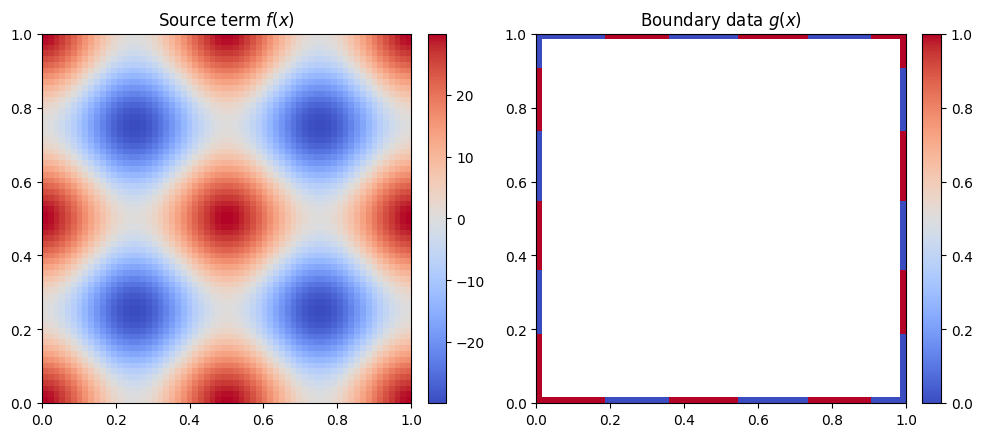

100%|██████████| 16/16 [00:00<00:00, 2853.87it/s]


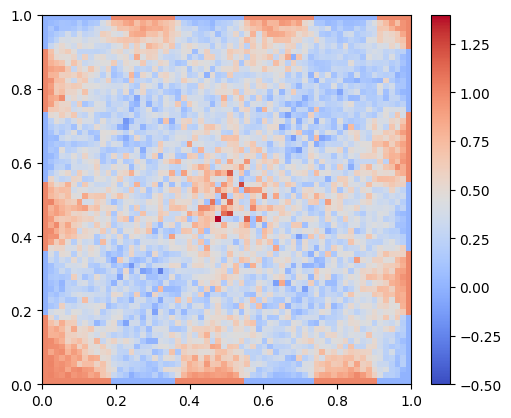

In [10]:
nWalks = 32
maxSteps = 64
epsilon = 1e-2
nPixels = 64
size = 1.0
rng = np.random.default_rng()

def closestPointOnSegment(x, a, b):
  '''
  Return the position of the closest point on a segment defined by endpoints
  `a` and `b`, to a point `x`.
  '''
  ba = b-a
  xa = x-a
  t = np.clip(np.dot(xa,ba)/np.dot(ba,ba), 0., 1.)
  return a + t*ba

def closestPoint(x, segments):
  '''
  Return the position of the closest point on any of the linear segments in the
  set `segments`, to a point `x`.
  '''
  cps = np.array([closestPointOnSegment(x, seg[0], seg[1]) for seg in segments])
  id = np.argmin([np.linalg.norm(cp-x) for cp in cps])
  return cps[id]

class HeatDiffusion(DirichletPoissonProblem):

  def g(self, x):
    '''
    Evalulate the boundary data function g(x).
    '''
    ti = int(x[0] * 5.5) % 2 == 0
    tj = int(x[1] * 5.5) % 2 == 0
    return 1.0 if ti==tj else 0.0

  def f(self, x):
    '''
    Evalulate the source term f(x).
    '''
    return 15*(np.cos(x[0]*(4.*np.pi)/size) + np.cos(x[1]*(4.*np.pi)/size))

  def closestPoint(self, x):
    nodes = np.array([[0.0, 0.0], [size, 0.0], [size, size], [0, size]])
    nNodes = len(nodes)
    segments = np.array([[nodes[i], nodes[(i-1)%nNodes]] for i in range(nNodes)])
    return closestPoint(x, segments)

def solve(solver, rng, i, j):
  x = np.array([size/nPixels*(i+0.5), size/nPixels*(j+0.5)])
  return solver.solve(rng, x)

solver = HeatDiffusion(nWalks, maxSteps, epsilon)

# First plot f(x), g(x).
plt.figure()
ax_f = plt.subplot(1, 3, 1)
im_f = ax_f.imshow([[solver.f(np.array([size/nPixels*(i+0.5), size/nPixels*(j+0.5)])) for j in range(nPixels)] for i in range(nPixels)], interpolation='none', cmap=plt.cm.coolwarm,
               origin='lower', extent=[0, size, 0, size])
ax_f.set_title(r'Source term $f(x)$')
plt.colorbar(im_f, ax=ax_f, fraction=0.046, pad=0.04)

ax_g = plt.subplot(1, 3, 2)
h = size*0.02
im_g = ax_g.imshow([[solver.g(np.array([size/nPixels*(i+0.5), size/nPixels*(j+0.5)])) if size/nPixels*(i+0.5)<h or size/nPixels*(i+0.5)>size-h or size/nPixels*(j+0.5)<h or size/nPixels*(j+0.5)>size-h else np.inf \
                     for j in range(nPixels)] for i in range(nPixels)], interpolation='none', cmap=plt.cm.coolwarm,
                   origin='lower', extent=[0, size, 0, size])
plt.colorbar(im_g, ax=ax_g, fraction=0.046, pad=0.04)
ax_g.set_title(r'Boundary data $g(x)$')

plt.subplots_adjust(left=0.01, right=2.2)
plt.show()

# Solve Dirichlet-Poisson problem

def solveTile(tile, solver, rng, iStart, jStart):
  (height, width) = tile.shape
  for i in range(height):
    for j in range(width):
      tile[i,j] = solve(solver, rng, iStart+i, jStart+j)[0]
  return (tile, iStart, jStart)

def solveMultiprocessing():
  nCores = mp.cpu_count()
  tileSize = int(nPixels/4)
  nTilesWidth = math.ceil(nPixels/tileSize)
  nTilesHeight = math.ceil(nPixels/tileSize)
  nTiles = nTilesWidth * nTilesHeight
  rng = np.random.default_rng()
  rngs = rng.spawn(nTiles)
  u = np.empty((nPixels, nPixels))
  args = [(u[i*tileSize: min((i+1)*tileSize, nPixels), j*tileSize:min((j+1)*tileSize, nPixels)], \
    solver, rngs[i*nTilesWidth+j],
    i*tileSize, j*tileSize) for j in range(nTilesWidth) for i in range(nTilesHeight)]
  with mp.Pool(nCores) as p:
    res = p.starmap(solveTile, tqdm.tqdm(args, total=nTiles, position=0, leave=True))
  # Combine results.
  for (tile, i, j) in res:
    (height, width) = tile.shape
    u[i:i+height, j:j+width] = tile
  return u

bGrid = solveMultiprocessing()

plt.figure()
bImage = plt.imshow(np.transpose(bGrid, axes=[1,0]), interpolation='none', cmap=plt.cm.coolwarm, origin='lower', extent=[0, size, 0, size])
bImage.set_clim(-0.5, 1.4)
plt.colorbar(bImage, fraction=0.046, pad=0.04)

# WoS for Dirichlet-Poisson Problems (plus gradient estimation)

We can also easily build a WoS estimator for the gradient $\nabla u$ of the solution to the above Dirichlet-Poisson problem. Like the solution to a Laplace problem, the gradient $\nabla u(x)$ evaluated at $x$ can also be expressed via a mean value-like principle,

$$
\begin{align*}
\nabla u(x) = \frac{1}{|B_R(x)|}\int_{\partial B_R(x)} u(y)\nu(y)\ \rm{d}y + \int_{B_R(x)} f(y)\nabla G(x,y) \rm{d}y
\end{align*}
$$

where for a ball of radius $R$, and $\nu(y) := (y-x)/R$ is the outward-pointing unit normal of the ball at $y$.

Again using a one-sample rule, a simple WoS estimator for $\nabla u$ is

$$
\begin{align*}
&\widehat{\nabla u}(x_0) = \frac{n}{R} \widehat{u}(x_1)\nu(x_1) + \sum_{x\in\text{walk}} \widehat{v}(x) & x_1 \sim U(\partial B_R(x_0))
\end{align*}
$$

and at each step of the walk, we add a contribution stemming from the source term,
$$
\begin{align*}
\widehat{v}(x) &:= \rm{Area}\left(B_R(x)\right) \cdot f(y) \cdot \nabla G(x,y) & y\sim U(B_R(x_0)).
\end{align*}
$$

where $n$ is the dimension of the domain (in all of these examples, $n=2$), $x_1$ is a point sampled uniformly at random on a sphere of maximal radius $R$ around $x_0$, and $y$ is a point sampled from within the ball of radius $R$ around $x_0$ (see diagram, from the paper [_Monte Carlo Geometry Processing_](https://www.cs.cmu.edu/~kmcrane/Projects/MonteCarloGeometryProcessing/paper.pdf).)

If the source term `f` is constant (like it will be in the following application), then our WoS estimate actually just simplifies to

$$
\begin{align*}
&\widehat{\nabla u}(x_0) = \frac{n}{R} \widehat{u}(x_1)\nu(x_1) & x_1 \sim U(\partial B_R(x_0)).
\end{align*}
$$

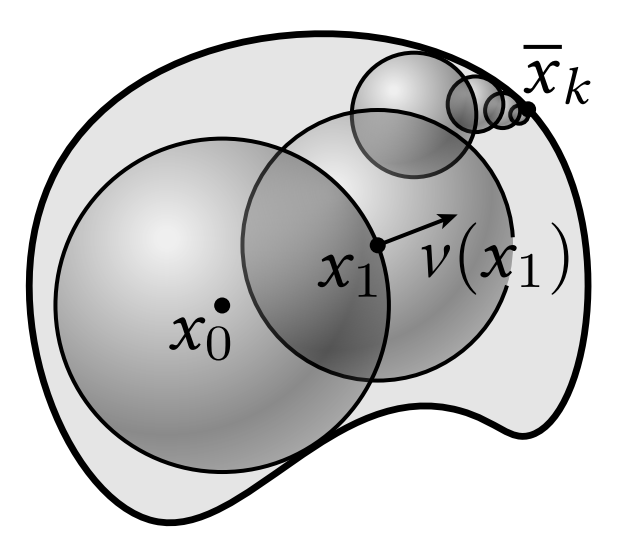

In [11]:
class DirichletPoissonProblem(DirichletProblem):

  def nu(self, x,y,R):
    return (y-x)/R

  def solve(self, rng, x, d=1):
    estimate = np.zeros(d)
    grad_estimate = np.zeros(2)
    for walk in range(self.nWalks):
      curr_estimate = np.zeros(d)
      x_new = x.copy()
      x1 = x_new.copy()
      x1_source = 0
      R1 = epsilon
      for step in range(self.maxSteps):
        # Determine the minimum distance to the domain boundary.
        cp = self.closestPoint(x_new)
        R = np.linalg.norm(x_new - cp)
        if R < self.epsilon:
          break
        y = sampleFrom2DBall(rng, x_new, R)
        curr_step = (np.pi*(R**2))*self.f(y) * self.G(R, x_new, y)
        curr_estimate += curr_step
        x_new = sampleFrom1DSphere(rng, x_new, R)
        if step == 0:
          R1 = R
          x1_source = curr_step
          x1 = x_new.copy()

      # Add contribution of boundary value to estimate.
      curr_estimate += self.g(cp)
      estimate += curr_estimate
      grad_estimate += (2/R1)*(curr_estimate-x1_source)*self.nu(x, x1, R1)


    return (estimate/self.nWalks, grad_estimate/nWalks)

  def G(self, R, x, y):
    '''
    Evaluate the harmonic Green's function on the ball of radius `R` centered at
    `x`, evaluated at `y`.
    '''
    r = np.linalg.norm(x-y)
    return 0.5/np.pi * np.log(R/r)

  def dG(self, R, x, y):
    '''
    Evaluate the gradient of the Green's function on the ball of radius `R`
    centered at `x`, evaluated at `y`.
    '''
    r2 = np.dot(x-y,x-y)
    return (x-y)/r2

  def f(self, x):
    '''
    Evaluate the source term f(x).
    '''
    pass


## Curve inflation
Run the following cell to see a fun application of "inflating curves" (based on [this algorithm](https://alecjacobson.com/weblog/media/notes-on-inflating-curves-2009-baran.pdf)). Rendering the image might take 1-2 minutes.


100%|██████████| 16/16 [00:00<00:00, 1302.81it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


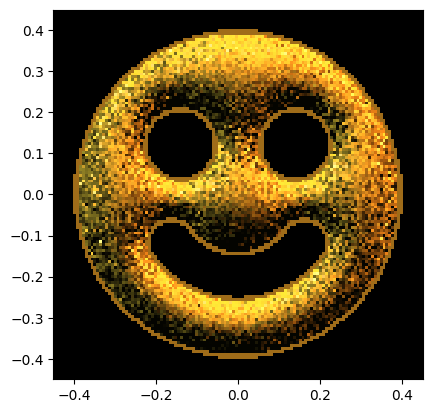

In [12]:
nWalks = 32
maxSteps = 64
epsilon = 1e-2
nPixels = 128
size = 0.45

class CurveInflation(DirichletPoissonProblem):

  def closestPoint(self, x):
    d_circle = abs(self.circleSDF(x, c=np.array([0.,0.]), r=0.4))
    d_eye1 = abs(self.circleSDF(x, c=np.array([-0.14,0.12]), r=0.08))
    d_eye2 = abs(self.circleSDF(x, c=np.array([0.14,0.12]), r=0.08))
    d_mouth = abs(self.arcSDF(x, sc=np.array([np.sin(0.7*np.pi),np.cos(0.7*np.pi)]), ra=0.2, rb=0.05, c=np.array([0.,0.])))
    dists = np.array([d_circle, d_eye1, d_eye2, d_mouth])
    id = np.argmin(dists)
    return self.sphereTrace(x, id)

  def sphereTrace(self, x, id):
    xprime = x.copy()
    while True:
      d = self.SDF(xprime, id)
      if abs(d) < self.epsilon: return xprime
      xprime -= d*self.gradientSDF(xprime, id)

  def gradientSDF(self, x, id, eps=1e-3):
    dx = np.array([eps, 0])
    dy = np.array([0, eps])
    ddx = self.SDF(x+dx, id) - self.SDF(x-dx, id)
    ddy = self.SDF(x+dy, id) - self.SDF(x-dy, id)
    g = np.array([ddx, ddy])
    g /= np.linalg.norm(g)
    return g

  def SDF(self, x, id):
    if id==0:
      return self.circleSDF(x, c=np.array([0.,0.]), r=0.4)
    elif id==1:
      return self.circleSDF(x, c=np.array([-0.14,0.12]), r=0.08)
    elif id==2:
      return self.circleSDF(x, c=np.array([0.14,0.12]), r=0.08)
    else:
      return self.arcSDF(x, sc=np.array([np.sin(0.7*np.pi),np.cos(0.7*np.pi)]), ra=0.2, rb=0.05, c=np.array([0.,0.]))

  def circleSDF(self, x, c, r):
    return np.linalg.norm(x-c) - r

  def arcSDF(self, x, sc, ra, rb, c):
    p = x.copy() - c
    p[0] = abs(p[0])
    if sc[1]*p[0] < sc[0]*p[1]:
      return np.linalg.norm(p-sc*ra) - rb
    return abs(np.linalg.norm(p)-ra) - rb

  def isInside(self, x):
    d_circle = self.circleSDF(x, c=np.array([0.,0.]), r=0.4)
    d_eye1 = self.circleSDF(x, c=np.array([-0.14,0.12]), r=0.08)
    d_eye2 = self.circleSDF(x, c=np.array([0.14,0.12]), r=0.08)
    d_mouth = self.arcSDF(x, sc=np.array([np.sin(0.7*np.pi),np.cos(0.7*np.pi)]), ra=0.2, rb=0.05, c=np.array([0.,0.]))
    return (d_circle < 0.) and (d_eye1 > 0.) and (d_eye2 > 0.) and (d_mouth > 0.0)

  def g(self, x):
    return 0.0

  def f(self, x):
    return 4.0

def computePixelColor(xy, wos):
  Kd = 0.4*np.array([0.95,0.85,0.15])
  Ks = 0.4*np.array([1., 1., 1.])
  Kf = 0.5*0.4*Ks
  Ka = 0.5*0.1*Kd

  u = wos[0][0]
  g = np.array(wos[1])
  z = np.sqrt(max(u, 1e-8))
  n = -0.5*g/z
  n = np.append(n, 1.)
  n /= np.linalg.norm(n)

  lights = np.array([[1.5,2.,1.], [-1.5,2.,1.]])
  Kl = np.array([[1.,0.6,0.6], [.6,0.6,1.0]])
  p = np.array([xy[0], xy[1], z])
  c = np.array([0., 0., 5.0])
  v = (c-p) / np.linalg.norm(c-p)

  color = np.zeros(3)
  for i in range(len(lights)):
    d = max(np.dot(n, lights[i]), 0.)
    h = lights[i]+v
    h /= np.linalg.norm(h)
    s = max(np.dot(n,h), 0.) ** 100
    color += Kl[i] * (Kd*d + Ks*s)
  NE = np.dot(n,v)
  f = max(np.sqrt(1.-NE*NE), 0.) ** 100
  color += Kf*f + Ka
  return color

solver = CurveInflation(nWalks, maxSteps, epsilon)

def solveCurveInflation(solver, rng, i, j):
  xy = np.array([-size+(2*size/nPixels)*(i+0.5), -size+(2*size/nPixels)*(j+0.5)])
  if solver.isInside(xy): return computePixelColor(xy, solver.solve(rng, xy))
  return np.zeros(3)

def solveTile(tile, solver, rng, iStart, jStart):
  (height, width, _) = tile.shape
  for i in range(height):
    for j in range(width):
      tile[i,j] = solveCurveInflation(solver, rng, iStart+i, jStart+j)
  return (tile, iStart, jStart)

def solve():
  nCores = mp.cpu_count()
  tileSize = int(nPixels/4)
  nTilesWidth = math.ceil(nPixels/tileSize)
  nTilesHeight = math.ceil(nPixels/tileSize)
  nTiles = nTilesWidth * nTilesHeight
  rng = np.random.default_rng()
  rngs = rng.spawn(nTiles)
  u = np.empty((nPixels, nPixels, 3))
  args = [(u[i*tileSize: min((i+1)*tileSize, nPixels), j*tileSize:min((j+1)*tileSize, nPixels)], \
    solver, rngs[i*nTilesWidth+j],
    i*tileSize, j*tileSize) for j in range(nTilesWidth) for i in range(nTilesHeight)]
  with mp.Pool(nCores) as p:
    res = p.starmap(solveTile, tqdm.tqdm(args, total=nTiles, position=0, leave=True))
  # Combine results.
  for (tile, i, j) in res:
    (height, width, _) = tile.shape
    u[i:i+height, j:j+width, :] = tile
  return u

bGrid = solve()
bImage = plt.imshow(np.transpose(bGrid, axes=[1,0,2]), interpolation='none', origin='lower', extent=[-size, size, -size, size])